### Import all relevant dependencies

In [1]:
import sys
import os

import pandas as pd


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from pathlib import Path
import yaml
from src.minimizer.minimizer_library.differential_evolution_parallel import DifferentialEvolutionParallel
from src.statistical_models.statistical_model_library.fcs_gaussian_noise_model import FCSGaussianNoiseModel
from src.visualization.plotting_functions import *
from src.math_utils.experiment_metrics import calculate_estimator_metrics
from src.math_utils.derivatives.numeric_derivative_calculator import NumericDerivativeCalculator
from src.model.hahn_stack_model import HahnStackModel
from src.math_utils.scaler.hahn_parameter_scaler import HahnParameterScaler
from src.model.parameter_set.hahn_parameter_set import HahnParameterSet
from src.utils.experiment_serialization import import_experiment_results

### Define the Experiment bounds for the free parameters as well as operating conditions, experiment repetitions and true parameter set

In [2]:
path = "../data/config/oed_config_demo.yaml"

with open(path, "r") as f:
    config = yaml.safe_load(f)

number_designs = config["number_designs"]  #Amount of LH Designs
n_rep = config["n_rep"]  #Amount of experiment repetitions
n_current_values = config["n_current_values"]  #Amount of individual current values
sigma = config["sigma"]  #experiment variance (10mV variance in repeated experiments)
number_new_designs = config["number_new_designs"]

# lower and upper bounds for operating conditions
upper_bounds_operating_conditions = np.array(config["upper_bounds_operating_conditions"])
lower_bounds_operating_conditions = np.array(config["lower_bounds_operating_conditions"])

I_S_array = np.linspace(1, 480, n_current_values)  # initialize applicable current array request

# initialize applicable parameter set
unscaled_theta_true = np.array(list(HahnParameterSet().free_parameters.values())[:6])
names_theta = list(HahnParameterSet().free_parameters.keys())[:6]

# initialize lower and upper bounds for free parameter values
unscaled_upper_bounds_free_params = np.array(config["unscaled_upper_bounds_free_params"])
unscaled_lower_bounds_free_params = np.array(config["unscaled_lower_bounds_free_params"])

print(names_theta, unscaled_lower_bounds_free_params, unscaled_theta_true, unscaled_upper_bounds_free_params)

['E_A', 'j_0_ref', 'r_el', 'D_CL_ref', 'D_GDL_ref', 'f_CL'] ['1000' '100' '1e-7' '1e-9' '1e-7' '0.01'] [7.1477e+04 2.1308e+03 4.2738e-06 3.3438e-08 8.6266e-06 3.6693e-01] ['100000' '10000' '1e-5' '1e-7' '1e-5' '1']


In [3]:
scaler = HahnParameterScaler()

X_train = np.vstack([
    unscaled_lower_bounds_free_params,
    unscaled_upper_bounds_free_params
]).T

# Stack operating condition bounds (rows = condition, columns = [min, max])
operating_condition_bounds = np.vstack([
    lower_bounds_operating_conditions,
    upper_bounds_operating_conditions
]).T

# Determine current range for scaling
current_bounds = np.array([[I_S_array.min(), I_S_array.max()]])

stacked_params = np.vstack((operating_condition_bounds, current_bounds))
scaled_theta_true = scaler.scale_theta(unscaled_theta_true, X_train)

scaled_upper_bounds = scaler.scale_params(upper_bounds_operating_conditions, operating_condition_bounds)
scaled_lower_bounds = scaler.scale_params(lower_bounds_operating_conditions, operating_condition_bounds)

scaled_lower_bounds_theta, _ = scaler.scale(unscaled_lower_bounds_free_params, X_train)
scaled_upper_bounds_theta, _ = scaler.scale(unscaled_upper_bounds_free_params, X_train)

# Print results
print("Scaled theta:", scaled_theta_true)
print("Rescaled theta:", unscaled_theta_true)

Scaled theta: [0.71188889 0.20513131 0.42159596 0.32765657 0.86127273 0.36053535]
Rescaled theta: [7.1477e+04 2.1308e+03 4.2738e-06 3.3438e-08 8.6266e-06 3.6693e-01]


### Define the parametric function including handover of bounds

In [4]:
hahn_fc_model = HahnStackModel(parameter_set=HahnParameterSet())
calculator = NumericDerivativeCalculator(hahn_fc_model, scaler)

statistical_model = FCSGaussianNoiseModel(model_function=hahn_fc_model,
                                          der_function=calculator,
                                          lower_bounds_x=scaled_lower_bounds,
                                          upper_bounds_x=scaled_upper_bounds,
                                          lower_bounds_theta=scaled_lower_bounds_theta,
                                          upper_bounds_theta=scaled_upper_bounds_theta,
                                          sigma=sigma,
                                          scaler = scaler,)

def blackbox_model(x):
    return statistical_model.random(theta=scaled_theta_true, x=x)

### Import LH-Designs

In [5]:
import_path = ".." / Path("data") / "experimental_designs" / "lhc"
# Read lhc from file system
lhc_data = pd.read_csv(import_path/"lhc_demo.csv")
LH = lhc_data.values[:,:len(names_theta)]

### Evaluate Cell Voltage for LH-Designs with repetitions

In [25]:
def plot_blackbox_evaluation(inputs_with_current, evaluations, input_labels=None, title_suffix="", fontsize=10, save_path=None):
    """
    Plots evaluation results vs each input dimension and a histogram of the output.
    Displays the number of samples for each plot.

    Parameters:
        inputs_with_current (ndarray): shape (n_samples, n_features)
        evaluations (ndarray): shape (n_samples,)
        input_labels (list of str): labels for each input dimension
        title_suffix (str): optional string to append to plot titles
    """
    inputs_with_current = np.array(inputs_with_current)
    evaluations = np.array(evaluations)

    # u_cell_label = r'$U~\mathrm{V}$'

    n_samples, n_features = inputs_with_current.shape

    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['mathtext.fontset'] = 'cm'

    if input_labels is None:
        input_labels = [f"Var{i + 1}" for i in range(n_features)]

    # -------- 1. Scatter Plots: Inputs vs Output --------
    fig, axs = plt.subplots(4, 1, figsize=(7, 0.7*3 * ((n_features + 1))))
    axs = axs.ravel()

    for i in range(n_features):
        axs[i].scatter(inputs_with_current[:, i], evaluations, alpha=0.6)
        axs[i].set_ylabel(r'$U~\mathrm{[V]}$', fontsize=fontsize)
        # else:
        #     axs[i].yaxis.set_ticklabels([])

        axs[i].set_xlabel(input_labels[i], fontsize=fontsize)
        # axs[i].set_title(
        #     f"{input_labels[i]} vs Cell Voltage {title_suffix}\n(n = {n_samples})",
        #     fontsize=10
        # )
        axs[i].grid(True)

    for j in range(n_features, len(axs)):
        fig.delaxes(axs[j])  # remove unused axes

    plt.tight_layout()
    # plt.grid(True)
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

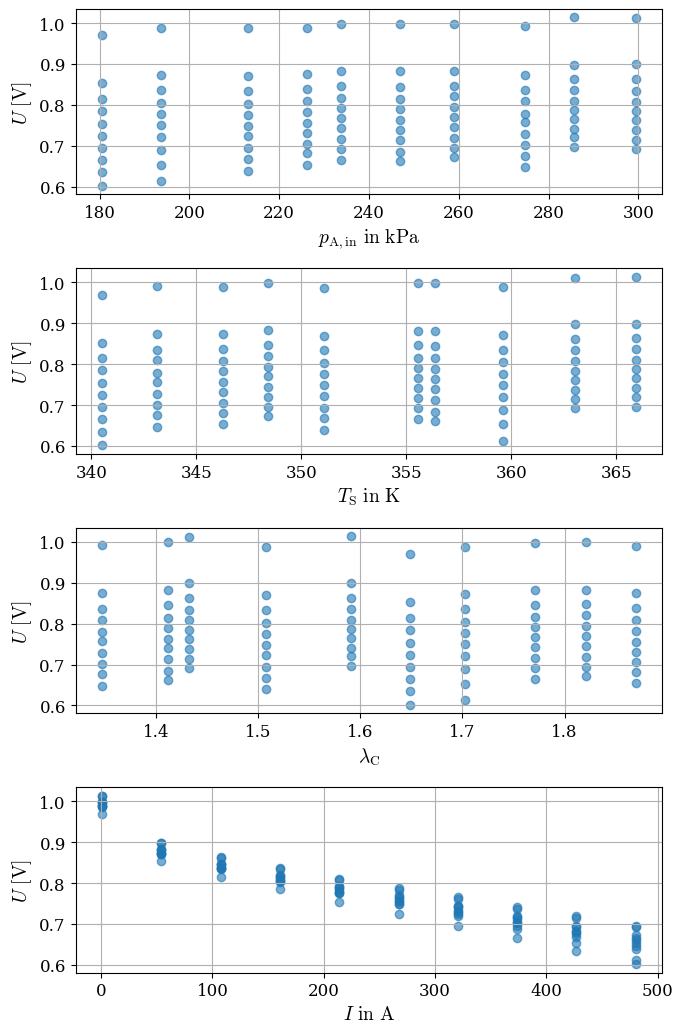

In [26]:
evaluation_LH_experiment = lhc_data.values[:,-1]
x_LH_oedesign = LH[:,:-1]

n_plot = number_designs*n_current_values*1

x_LH_oedesign_plot = x_LH_oedesign * np.array([1e-3,1,1,1])
opCons = [r"$p_\mathrm{A,in}~\mathrm{in~kPa}$", r'$T_\mathrm{S}~\mathrm{in~K}$', r'$\lambda_\mathrm{C}$', r'$I~\mathrm{in~A}$']

plot_blackbox_evaluation(x_LH_oedesign_plot[:n_plot], evaluation_LH_experiment[:n_plot], fontsize=14,
                         input_labels=opCons)

In [8]:
import_path = ".." / Path("data") / "estimated_parameters" / "lhc"
scaled_estimated_thetas = pd.read_csv(import_path / "estimated_thetas_demo.csv").values

In [9]:
from src.math_utils.experiment_metrics import calculate_experiment_metrics

x0_LH_oedesign = x_LH_oedesign[:n_current_values*number_designs,:]

(FIM_LH_experiment,
 det_FIM_LH_experiment,
 diagonal_CRLB_LH_experiment,
 CRLB_LH_experiment,
 std_LH_Experiment) = calculate_experiment_metrics(statistical_model, scaled_theta_true, x0_LH_oedesign)

print(f"total amount of LH designs with current and repetitions: {len(x_LH_oedesign)}")
print(f"total amount of LH designs with current: {len(x0_LH_oedesign)}")
print(f"FIM LH experiment:\n {FIM_LH_experiment}")
print(f"determinant of FIM:\n {det_FIM_LH_experiment}")
print("CRLB of Latin Hypercube experiment at initial theta: \n",
      diagonal_CRLB_LH_experiment)
print('The relative expected standard deviations of the LH estimators are \n',
      std_LH_Experiment)

total amount of LH designs with current and repetitions: 100000
total amount of LH designs with current: 100
FIM LH experiment:
 [[   39302.41737795    -9901.80244565     8243.29487928   -20519.34895818
     -1721.25729829    -5647.87442435]
 [   -9901.80244565  1420040.58362301 -1182195.92144363   633740.41955027
    153383.11625482   295750.30806161]
 [    8243.29487928 -1182195.92144363  1381825.98697916  -786734.58986507
   -201685.87476344  -351714.15441963]
 [  -20519.34895818   633740.41955027  -786734.58986507   497357.60182136
    129516.75257281   207845.19011304]
 [   -1721.25729829   153383.11625482  -201685.87476344   129516.75257281
     35484.67400206    53343.77904154]
 [   -5647.87442435   295750.30806161  -351714.15441963   207845.19011304
     53343.77904154    90865.02896378]]
determinant of FIM:
 1.2072062204819078e+26
CRLB of Latin Hypercube experiment at initial theta: 
 [4.54961603e-05 2.91092975e-06 2.36274348e-04 3.61496250e-04
 9.94405346e-04 7.78682734e-03]


### calculate and plot metrics of LH-Designs

In [10]:
from scipy.stats import norm

def plot_ols_vs_crlb(theta_samples, crlb_vars, theta_true, lower_bounds,
                     upper_bounds, param_names=None, parameter_factors=None, save_path=None, first_ten=False):
    """
    Plot OLS histograms and overlay CRLB-based Gaussian curves.

    Parameters
    ----------
    theta_samples : array-like of shape (n_samples, n_params)
        OLS estimates across multiple runs/samples.
    crlb_vars : array-like of shape (n_params,)
        CRLB variances for each parameter.
    param_names : list of str, optional
        Names of parameters to use for x-axis labels.
    """
    theta_samples = np.array(theta_samples)  # shape: (n_samples, n_params)
    n_params = theta_samples.shape[1]

    if parameter_factors is None:
        parameter_factors = np.ones(n_params)

    theta_samples *= parameter_factors
    theta_true = np.array(theta_true) * parameter_factors

    lower_bounds = lower_bounds * parameter_factors
    upper_bounds = upper_bounds * parameter_factors

    fig, axes = plt.subplots(2, n_params // 2, figsize=(2.7 * n_params,1.8*n_params))

    if n_params == 1:
        axes = [axes]

    j = 0
    for i in range(n_params):
        samples = theta_samples[:, i]
        mean_est = np.mean(samples)
        crlb_std = np.sqrt(crlb_vars[i])

        llim = mean_est-mean_est*2
        ulim = mean_est*3

        # Generate CRLB Gaussian curve
        x_vals = np.linspace(llim, ulim, 10000)

        # x_vals = np.linspace(0,1, 1000)
        y_vals = norm.pdf(x_vals, loc=mean_est, scale=crlb_std)

        if i == n_params // 2:
            j += 1

        ax = axes[j][i % (n_params // 2)]

        # Plot histogram
        ax.hist(samples, bins='scott', density=True, color='lightgray', edgecolor='black', label="OLS")

        # Plot CRLB Gaussian
        ax.plot(x_vals, y_vals, color='red', linewidth=2, label="CRLB")
        # ax.axvline(mean_est, color='green', linestyle='dashed', linewidth=2, label="Estimated θ")
        ax.axvline(theta_true[i], color='blue', linestyle='dashed', linewidth=2, label=r"$\theta_\mathrm{true}$")
        if first_ten and i == n_params - 1:
            ax.axvline(np.mean(samples[:10]), color='green', linestyle='dashed', linewidth=2, label=r"$\theta_{1-10}$")

        # Labels
        param_label = f"$\\theta_{{{i}}}$" if not param_names else param_names[i]
        ax.set_xlabel(param_label, fontsize=18)
        # ax.set_xlim(lower_bounds[i], upper_bounds[i])
        # ax.set_xlim(mean_est/4, mean_est*4)
        ax.set_xlim(mean_est-mean_est, mean_est*2)
        ax.set_ylabel(r"$\boldsymbol{\rho}$", fontsize=18)
        ax.tick_params(axis='both', labelsize=16)
        ax.legend(fontsize=16)
        ax.grid(True)





    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path)

    plt.show()

In [11]:
scaler.rescale_theta(np.array(scaled_estimated_thetas[0], dtype=float))
raw_estimated_thetas = [scaler.rescale_theta(np.array(theta, dtype=float)) for theta in scaled_estimated_thetas]
unscaled_upper_bounds_free_params = unscaled_upper_bounds_free_params.astype(float)
unscaled_lower_bounds_free_params = unscaled_lower_bounds_free_params.astype(float)

crlb_factor = unscaled_upper_bounds_free_params-unscaled_lower_bounds_free_params
unit_factors = np.array([1e-3, 1e-3, 1e4, 1e4, 1e4, 1])

crlb = diagonal_CRLB_LH_experiment*crlb_factor*crlb_factor*unit_factors*unit_factors



In [12]:
estimated_theta_mean, var_theta, rel_error, rel_std, _ = calculate_estimator_metrics(
    scaled_estimated_thetas, scaled_theta_true, diagonal_CRLB_LH_experiment)

print(f"Mean theta estimation: {scaler.rescale_theta(np.array(estimated_theta_mean, dtype=float))}")
print(f"Mean theta estimation normalized: {estimated_theta_mean}")
print(f"Variance of theta estimation: {var_theta}")
print(f"Relative error of theta estimation: {rel_error}")
print(f"Relative standard deviation of theta estimation: {rel_std}")


Mean theta estimation: [7.15033511e+04 2.13179321e+03 4.26697834e-06 3.35452738e-08
 8.60763045e-06 3.84216455e-01]
Mean theta estimation normalized: [0.71215506 0.20523164 0.4209069  0.32874014 0.85935661 0.37799642]
Variance of theta estimation: [4.54568741e-05 3.20955247e-06 2.35594404e-04 3.50165163e-04
 9.31785956e-04 1.06172856e-02]
Relative error of theta estimation: [ 0.0003739   0.00048907 -0.0016344   0.00330704 -0.00222475  0.04843094]
Relative standard deviation of theta estimation: [0.00947346 0.00874286 0.03642556 0.05717784 0.03549398 0.28973122]


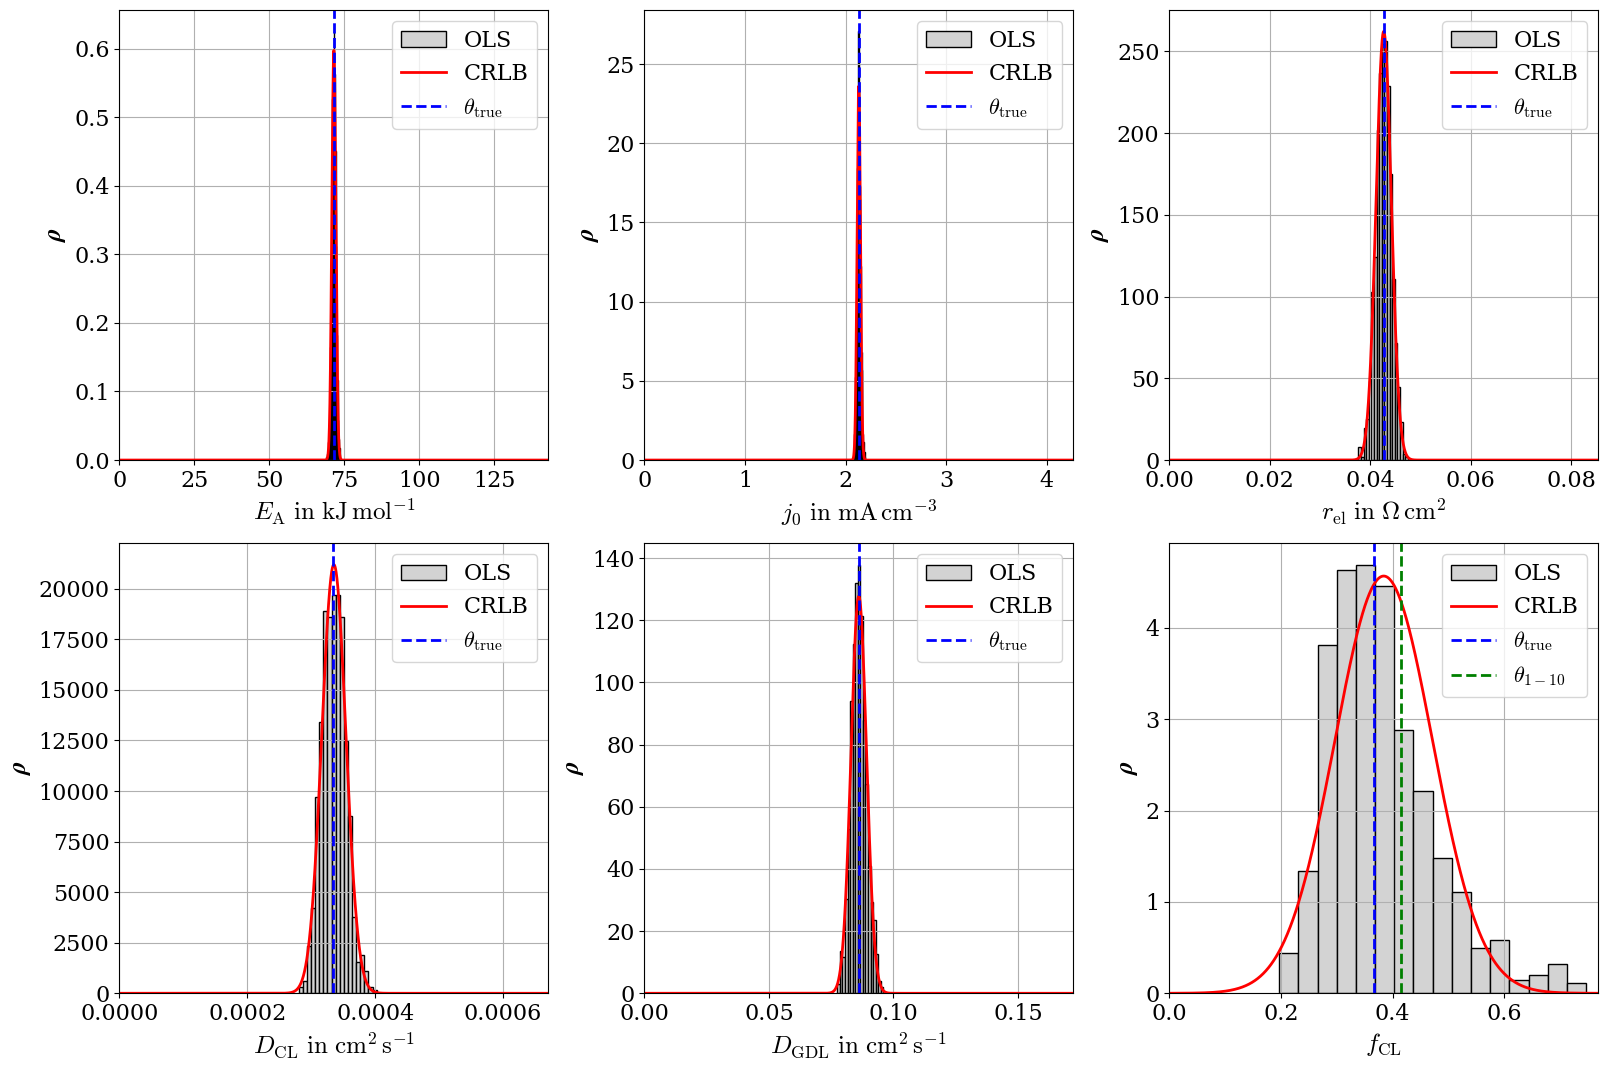

In [13]:
parameter_names = [
    r'${E}_{\mathrm{A}}~\mathrm{in}~\mathrm{kJ\,mol^{-1}}$',
    r'${j}_{0}~\mathrm{in}~\mathrm{mA\,cm^{-3}}$',
    r'${r}_{\mathrm{el}}~\mathrm{in}~\mathrm{\Omega\,cm^2}$',
    r'${D}_{\mathrm{CL}}~\mathrm{in}~\mathrm{cm^2\,s^{-1}}$',
    r'${D}_{\mathrm{GDL}}~\mathrm{in}~\mathrm{cm^2\,s^{-1}}$',
    r'${f}_{\mathrm{CL}}$'
]


plot_ols_vs_crlb(
    raw_estimated_thetas*unit_factors,  # <== this should be the OLS estimates!
    crlb,  # <== this should be the CRLB variances!
    unscaled_theta_true*unit_factors,
    unscaled_lower_bounds_free_params*unit_factors,
    unscaled_upper_bounds_free_params*unit_factors,
    first_ten = True,
    param_names=parameter_names,
)

In [14]:
def plot_experiment_matrix(experiments, opCons, fontsize=12, save_path=None):
    """
    Plots a matrix of scatter plots for all combinations of operational conditions.

    Parameters:
    - experiments: list of 2D arrays or lists, each of shape (n_samples, n_conditions)
    - opCons: list of strings, names of the operational conditions. Must match number of columns.

    Notes:
    - Assumes the first column is pressure in Pa and converts it to kPa.
    - Automatically scales axes to global min/max across all experiments.
    """
    num_conditions = len(opCons)

    # Convert all experiments to numpy arrays
    experiments = [np.array(exp) for exp in experiments]

    # Validate input dimensions
    for exp in experiments:
        if exp.ndim != 2 or exp.shape[1] != num_conditions:
            raise ValueError("Each experiment must be a 2D array with the same number of columns as opCons.")

    # Convert pressure from Pa to kPa (first column)
    experiments_converted = [np.copy(exp) for exp in experiments]
    for exp in experiments_converted:
        exp[:, 0] = exp[:, 0] / 1000  # Convert Pa to kPa

    # Compute global ranges with padding
    global_ranges = {}
    for i in range(num_conditions):
        all_values = np.concatenate([exp[:, i] for exp in experiments_converted])
        global_ranges[i] = [np.min(all_values) * 0.98, np.max(all_values) * 1.02]

    # Create plot
    fig = plt.figure(figsize=(4 * num_conditions, 4 * num_conditions))
    for i in range(num_conditions):
        for j in range(num_conditions):
            ax = fig.add_subplot(num_conditions, num_conditions, i * num_conditions + j + 1)
            for exp in experiments_converted:
                ax.scatter(exp[:, j], exp[:, i], s=50, alpha=0.8)
            ax.set_xlabel(opCons[j], fontsize=fontsize)
            ax.set_ylabel(opCons[i], fontsize=fontsize)
            ax.grid(True)
            ax.set_xlim(global_ranges[j])
            ax.set_ylim(global_ranges[i])
            # set fontsize for axis labels
            ax.tick_params(axis='both', labelsize=fontsize)
            # print(i,j)
            # print(global_ranges[j])
            # print(global_ranges[i])

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

In [15]:
import_path = ".." / Path("data") / "experimental_designs" / "pi"
# Read oed from file system
oed_data = pd.read_csv(import_path/"pi_design_demo.csv")
oed = oed_data.values[:number_new_designs*n_current_values,:len(names_theta)]

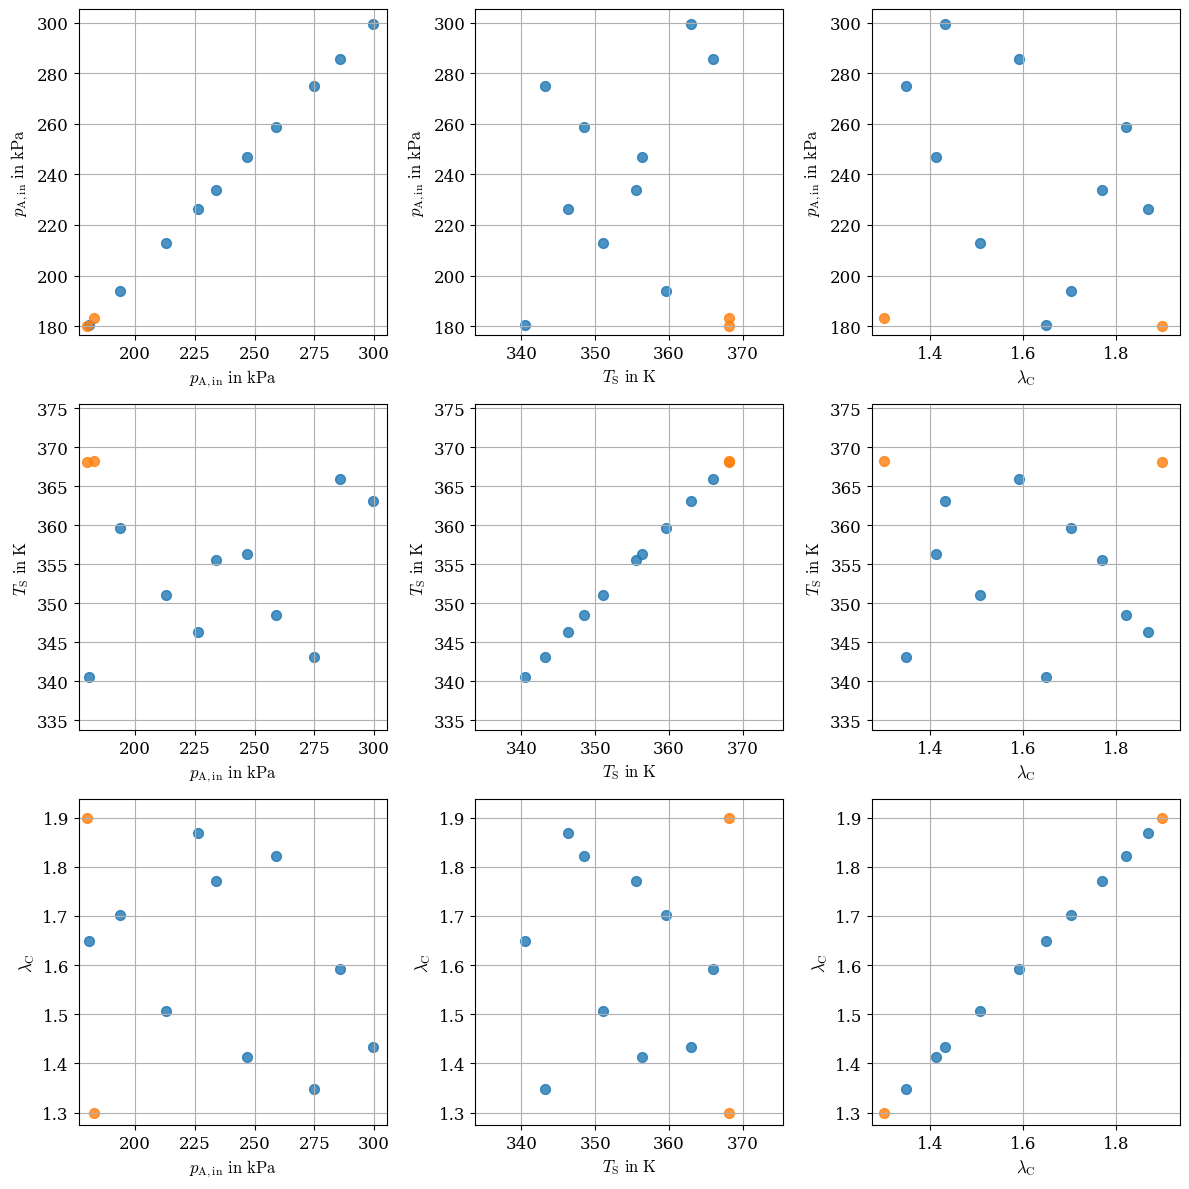

In [16]:
x0_oed=oed[:,:len(opCons[:-1])][range(0,number_new_designs*n_current_values,n_current_values)]
x0_LH=x0_LH_oedesign[:,:len(opCons[:-1])][range(0,number_designs*n_current_values,n_current_values)]
plot_experiment_matrix([x0_LH,x0_oed], opCons[:-1], fontsize=12)

In [17]:
LH_pi_design = np.vstack((x0_LH_oedesign, oed[:,:4]))

(FIM_LH_oed_experiment,
 det_FIM_LH_oed_experiment,
 diagonal_CRLB_LH_oed_experiment,
 CRLB_LH_oed_experiment,
 std_LH_oed_Experiment) = calculate_experiment_metrics(statistical_model, scaled_theta_true, LH_pi_design)

print(f"additional experimental designs from the Pi calculation:\n {x0_oed}")
print(
    f"total amount of experimental designs from LH + Pi: {len(LH_pi_design)}")  # should be number of (Pi-Designs + number of LH designs) * current values
print(f"FIM LH + Pi designs:\n {FIM_LH_oed_experiment}")
print(
    f"The determinant of the Fisher information matrix at the theta true and LH + Pi designs is \n{det_FIM_LH_oed_experiment}")
print("CRLB of Latin Hypercube Pi designs at theta true: \n", diagonal_CRLB_LH_oed_experiment)
print('The relative expected standard deviations of the Pi-optimal parameter estimators are \n',
      std_LH_oed_Experiment)

additional experimental designs from the Pi calculation:
 [[1.83058457e+05 3.68149864e+02 1.30000024e+00]
 [1.80000079e+05 3.68097526e+02 1.89999943e+00]]
total amount of experimental designs from LH + Pi: 120
FIM LH + Pi designs:
 [[   64104.43995107    74026.47560526   -61627.71397296    86188.51267076
     56145.3963336     23200.29596948]
 [   74026.47560526  1704048.69772694 -1418635.10441211   994753.20514673
    349096.55740103   393372.95567756]
 [  -61627.71397296 -1418635.10441211  1658191.184375   -1271119.36813567
   -489536.46189089  -478448.19499516]
 [   86188.51267076   994753.20514673 -1271119.36813567  1492361.30502466
    802425.27078488   452343.81264326]
 [   56145.3963336    349096.55740103  -489536.46189089   802425.27078488
    539221.76308617   208917.94727956]
 [   23200.29596948   393372.95567756  -478448.19499516   452343.81264326
    208917.94727956   153824.78909694]]
The determinant of the Fisher information matrix at the theta true and LH + Pi designs is

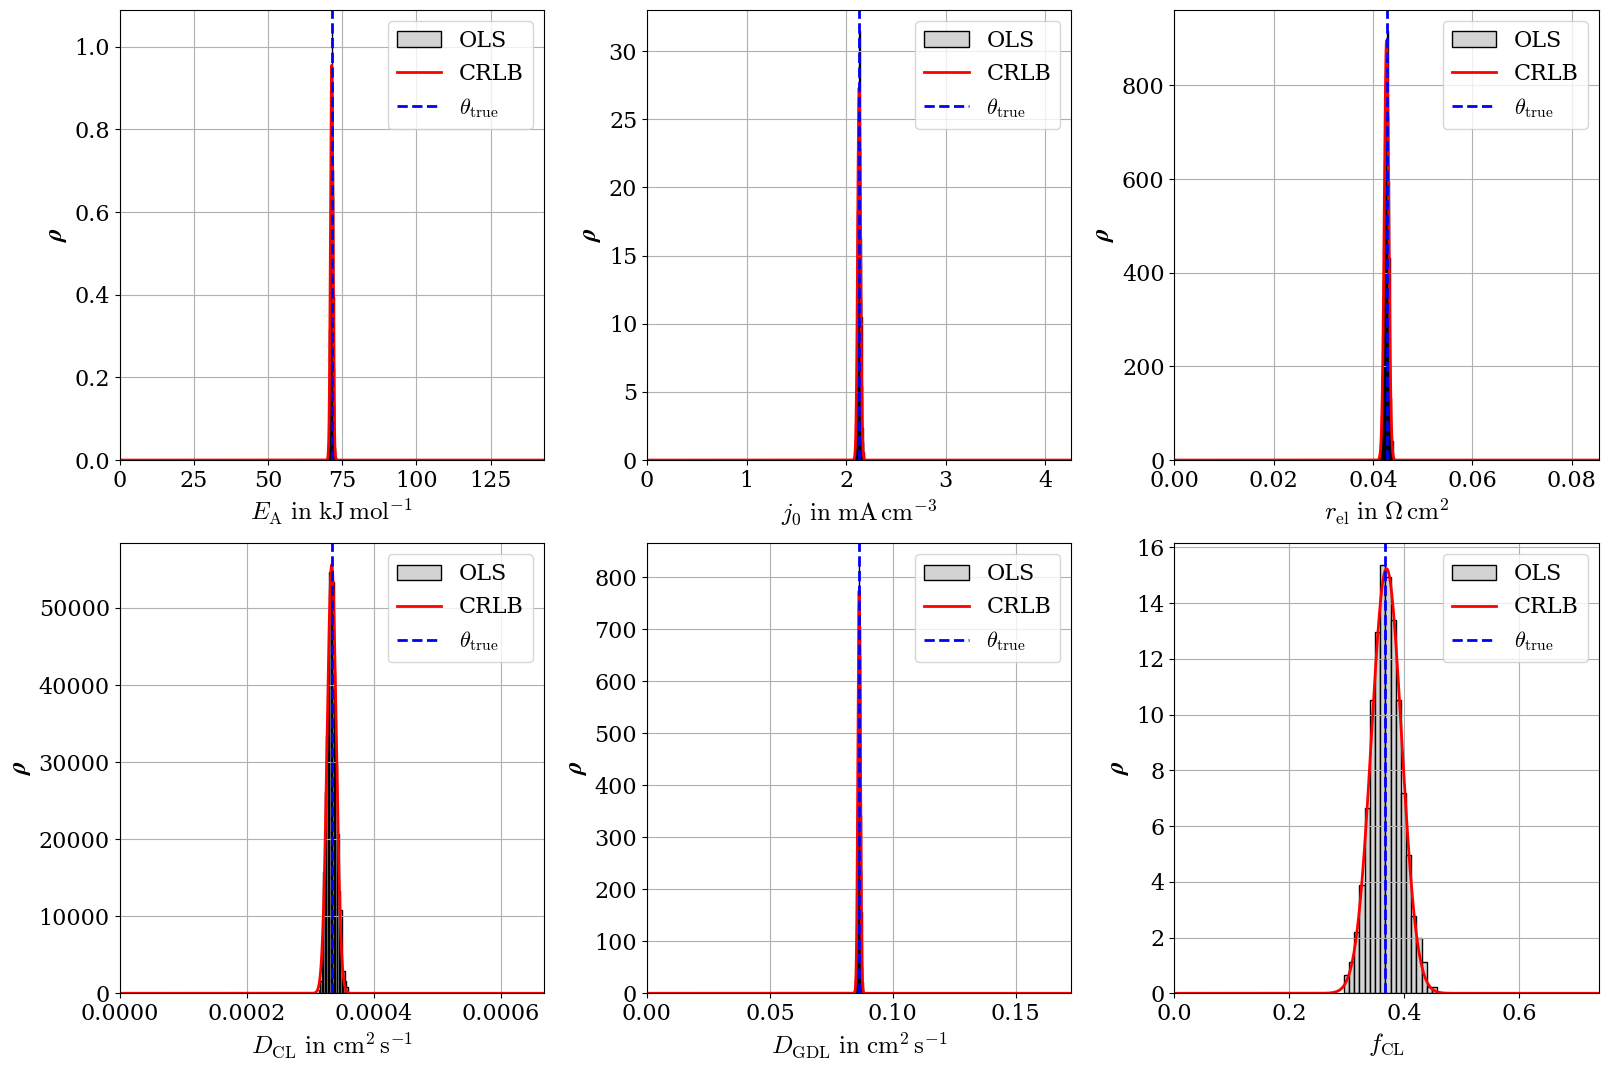

In [18]:
import_path = ".." / Path("data") / "estimated_parameters" / "pi"
scaled_estimated_thetas = pd.read_csv(import_path / "estimated_thetas_demo.csv").values

scaler.rescale_theta(np.array(scaled_estimated_thetas[0], dtype=float))
raw_estimated_thetas = [scaler.rescale_theta(np.array(theta, dtype=float)) for theta in scaled_estimated_thetas]

crlb_factor = unscaled_upper_bounds_free_params-unscaled_lower_bounds_free_params
unit_factors = np.array([1e-3, 1e-3, 1e4, 1e4, 1e4, 1])

crlb = diagonal_CRLB_LH_oed_experiment*crlb_factor*crlb_factor*unit_factors*unit_factors

plot_ols_vs_crlb(
    raw_estimated_thetas*unit_factors,  # <== this should be the OLS estimates!
    crlb,  # <== this should be the CRLB variances!
    unscaled_theta_true*unit_factors,
    unscaled_lower_bounds_free_params*unit_factors,
    unscaled_upper_bounds_free_params*unit_factors,
    param_names=parameter_names,
)

In [19]:
estimated_theta_mean, var_theta, rel_error, rel_std_oed, _ = calculate_estimator_metrics(
    scaled_estimated_thetas, scaled_theta_true, diagonal_CRLB_LH_oed_experiment)

print(f"Relative standard deviation of theta estimation: {rel_std_oed}")

Relative standard deviation of theta estimation: [0.00595227 0.00727514 0.01046784 0.02235828 0.00610944 0.07474388]


### LHC std progression

In [20]:
parameter_names = [
    r'${E}_{\mathrm{A}}$',       # E fett-kursiv, A fett aufrecht
    r'${j}_{0}$',  # j fett-kursiv, 0 normal, ref fett aufrecht
    r'${r}_{\mathrm{el}}$',     # r fett-kursiv, el fett aufrecht
    r'${D}_{\mathrm{CL}}$',  # D fett-kursiv, CL und ref fett aufrecht
    r'${D}_{\mathrm{GDL}}$', # analog
    r'${f}_{\mathrm{CL}}$'      # f fett-kursiv, CL fett aufrecht
]

import_path = ".." / Path("data") / "stats"

# Read oed from file system
lhc_std_data = pd.read_csv(import_path / "LHC_std_std_progression.csv", sep=';')
lhc_mean_data = pd.read_csv(import_path / "LHC_mean_std_progression.csv", sep=';')

lhc_mean_data.columns = parameter_names
lhc_std_data.columns = parameter_names

fontsize=18

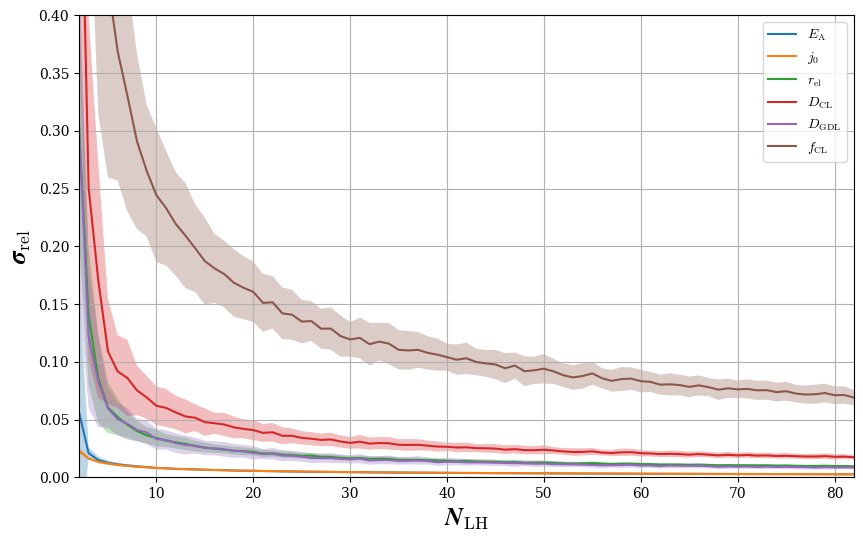

In [21]:
from matplotlib.ticker import MultipleLocator

n = len(lhc_mean_data)
lhc_mean_data.index = range(1, n+1)
lhc_std_data.index = range(1, n+1)
# Plot stat_mean with grid
ax = lhc_mean_data[1:].plot()
for col in lhc_mean_data.columns:
    ax.fill_between(lhc_mean_data.index[1:],
                    lhc_mean_data[col][1:] - lhc_std_data[col][1:],
                    lhc_mean_data[col][1:] + lhc_std_data[col][1:],
                    alpha=0.3)

plt.gcf().set_size_inches(10, 6)
# Enlarge font
plt.rcParams.update({'font.size': 12})
plt.ylim(0,0.4)
ax.yaxis.set_major_locator(MultipleLocator(0.05))
plt.ylabel(r'$\boldsymbol{\sigma}_\mathrm{rel}$', fontsize=fontsize)
plt.xlabel(r'$\boldsymbol{N}_\mathrm{LH}$', fontsize=fontsize)
plt.xlim(2, 82)
plt.grid()
# ax.tick_params(axis='both', fontsize=fontsize)
# plt.savefig(r'std_progression.png')
plt.show()

In [22]:
# Plot std bar diagram of OLS and compare LHC and OED
# Use logarithmic scale for y-axis
def plot_std_bars(std_lhc, std_oed, y_label=r'$\sigma_\mathrm{rel,OLS}$', names=["LHC", "OED"], log=False, save_path=None):
    # Beispiel-Daten: 12 Werte in 6 Paare (je 2 Werte pro Paar)
    labels = parameter_names
    werte1 = std_lhc
    werte2 = std_oed

    # Positionen für die Balkenpaare auf der x-Achse
    gruppen_position = np.arange(len(labels))
    bar_breite = 0.35

    fig, ax = plt.subplots(figsize=(len(std_lhc),0.75*len(std_oed)))

    # Balken für Werte 1 und 2 nebeneinander
    ax.bar(gruppen_position - bar_breite/2, werte1, bar_breite, label=names[0], alpha=0.8)
    ax.bar(gruppen_position + bar_breite/2, werte2, bar_breite, label=names[1], alpha=0.8)

    # Achsenbeschriftungen und Titel
    # ax.set_xlabel('Wertepaare')
    ax.set_ylabel(y_label, fontsize=14)
    ax.set_xticks(gruppen_position)
    ax.set_xticklabels(labels, fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.legend(fontsize=12)
    if log:
        # Use logarithmic scale für y-axis
        ax.set_yscale('log')
        # Set grid for y-axis also in between logarithmic steps
        ax.yaxis.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
    else:
        ax.grid(axis='y')
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

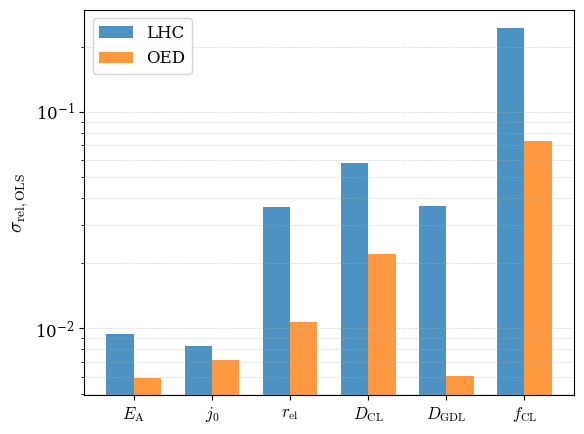

In [23]:
plot_std_bars(std_LH_Experiment, std_LH_oed_Experiment, log=True)

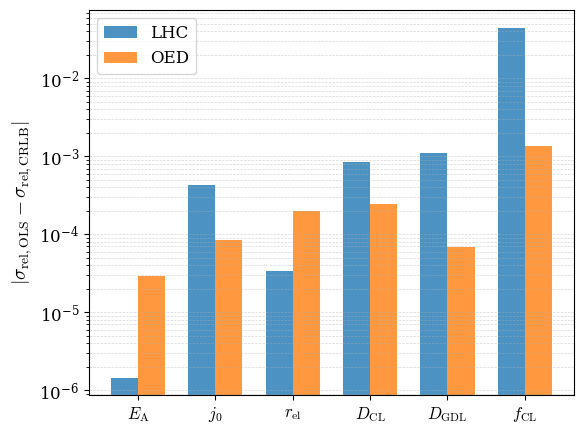

In [24]:
# Compute differences between empirical and CRLB std for LHC and OED
std_lhc_diff = np.abs(std_LH_Experiment - rel_std)
std_oed_diff = np.abs(std_LH_oed_Experiment - rel_std_oed)

# Plot bar plot of differences
plot_std_bars(std_lhc_diff, std_oed_diff, y_label=r'$|\sigma_\mathrm{rel,OLS} - \sigma_\mathrm{rel,CRLB}|$', names=["LHC", "OED"], log=True)